In [1]:
import os
import sys
sys.path.insert(0, '/tf')
import importlib

gpu_num = "0" # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Allows to exit cell execution in Jupyter
class ExitCell(Exception):
    def _render_traceback_(self):
        pass

# Import Sionna
import sionna
importlib.reload(sionna)

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

tf.random.set_seed(1) # Set global random seed for reproducibility

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time

# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, RIS

# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, channel_capacity, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement


In [33]:
# Load the scene
scene = load_scene("../test_scenes/hallway/hallway.xml")

print(f'size:{scene.size}' )
print(f'center:{scene.center}')


scene.remove("tx")
scene.remove("rx")
# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="V")

scene.rx_array = PlanarArray(num_rows=2,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="VH")
# Create transmitter
tx = Transmitter(name="tx",
                 position=[-4,0,2.5],orientation=[0,0,0])
rx = Receiver(name="rx",
                 position=[3,0,2.5],orientation=[0,0,0])
scene.add(tx)
scene.add(rx)

size:[10.02     20.04      5.020002]
center:[0.        0.        2.5000002]


In [34]:
subcarrier_spacing = 312.5e3
fft_size = 64
noise_floor = np.exp(0.1*(-174 + 10*np.log10(subcarrier_spacing) - 30 + 5))

frequencies = scene.frequency + subcarrier_frequencies(fft_size, subcarrier_spacing)

paths = scene.compute_paths(max_depth=1,
                                num_samples=10e6, reflection=True,scattering=True)  # Number of rays shot into directions defined
                                                # by a Fibonacci sphere, too few rays can
                                                # lead to missing paths
paths.normalize_delays = False
a, tau = paths.cir(reflection=False,scattering=False)
h_freq_env = cir_to_ofdm_channel(frequencies,
                                a,
                                tau,
                                normalize=False) # Non-normalized includes path-loss

tf.Tensor(
[[[[[[[ 3.3724133e-04-1.4211498e-03j  2.7168053e-04-1.4351265e-03j
        2.0563573e-04-1.4460679e-03j  1.3915896e-04-1.4539716e-03j
        7.2389827e-05-1.4588208e-03j  5.4686707e-06-1.4606055e-03j
       -6.1553066e-05-1.4593183e-03j -1.2826754e-04-1.4549729e-03j
       -1.9480166e-04-1.4475673e-03j -2.6101424e-04-1.4371048e-03j
       -3.2659018e-04-1.4236353e-03j -3.9147999e-04-1.4071752e-03j
       -4.5554753e-04-1.3877590e-03j -5.1865802e-04-1.3654276e-03j
       -5.8067898e-04-1.3402278e-03j -6.4148015e-04-1.3122127e-03j
       -7.0101192e-04-1.2813981e-03j -7.5891480e-04-1.2479771e-03j
       -8.1537571e-04-1.2118421e-03j -8.7004749e-04-1.1732075e-03j
       -9.2289166e-04-1.1321085e-03j -9.7379705e-04-1.0886312e-03j
       -1.0226567e-03-1.0428672e-03j -1.0694289e-03-9.9484692e-04j
       -1.1138908e-03-9.4479934e-04j -1.1560128e-03-8.9276698e-04j
       -1.1957576e-03-8.3878625e-04j -1.2328882e-03-7.8318920e-04j
       -1.2675243e-03-7.2579662e-04j -1.2994499e-03

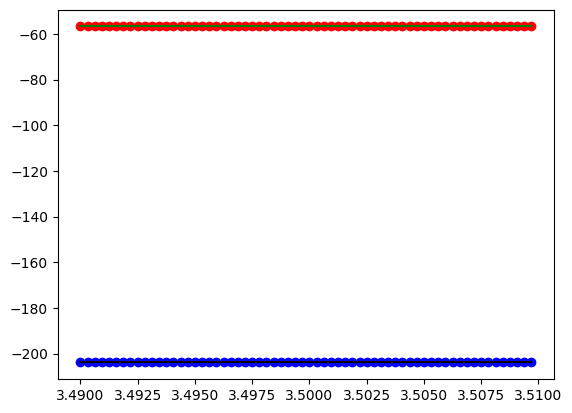

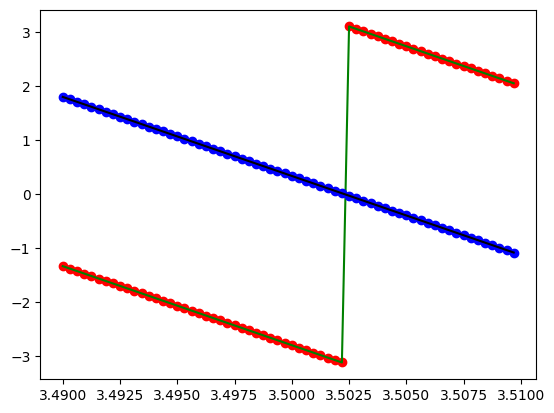

In [36]:
print(h_freq_env)
a = h_freq_env[0,0,0,0,0,0,:]
b = h_freq_env[0,0,1,0,0,0,:]
c = h_freq_env[0,0,2,0,0,0,:]
d = h_freq_env[0,0,3,0,0,0,:]


plt.figure();
plt.plot(frequencies/1e9,20*np.log10(a),'ro')
plt.plot(frequencies/1e9,20*np.log10(b),'g-')
plt.plot(frequencies/1e9,20*np.log10(c),'bo')
plt.plot(frequencies/1e9,20*np.log10(d),'k-')

plt.figure();
plt.plot(frequencies/1e9,np.angle(a),'ro')
plt.plot(frequencies/1e9,np.angle(b),'g-')
plt.plot(frequencies/1e9,np.angle(c),'bo')
plt.plot(frequencies/1e9,np.angle(d),'k-')


In [33]:
print(scene.transmitters['tx'])
orientation = tf.cast([0,0,np.pi/2],tf.float32)
print(scene.tx_array.rotated_positions(orientation=orientation))


tf.Tensor(
[[ 0.         -0.01514181  0.0151418 ]
 [ 0.          0.01514181 -0.0151418 ]], shape=(2, 3), dtype=float32)
